<a href="https://colab.research.google.com/github/luigibonati/ml4atomsim/blob/main/BPTI_protein_TICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modules

In [1]:
is_colab = False
is_reload = False

if is_colab:
    !pip install pyemma
    !pip install mdtraj
    !git clone https://github.com/luigibonati/ml4atomsim.git

    ## ONLY FOR GOOGLE DRIVE
    from google.colab import drive
    drive.mount('/gdrive')
    import sys
    sys.path.append('ml4atomsim/') 
    folder = "/gdrive/MyDrive/MD_datasets/"
else:
    folder = "data/bpti/"

In [2]:
if is_reload:
    if is_colab:
        !cd ml4atomsim; git pull
    from importlib import reload
    reload(stateinterpreter)
    reload(stateinterpreter.MD)
    reload(stateinterpreter.classifier)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mdtraj as md
import itertools

import pyemma
import pyemma.coordinates as coor


import stateinterpreter.MD


## Generate COLVAR
compute TICA components with pyemma

Descriptors list

1-2   -->PHE4 : chi1=[52,53,56,57]    , chi2=[53,56,57,58]

3-4   -->TYR10: chi1=[144,145,148,149], chi2=[145,148,149,150]

5-6   -->TYR21: chi1=[328,329,332,333], chi2=[329,332,333,334]

7-8   -->PHE22: chi1=[349,350,353,354], chi2=[350,353,354,355]

9-10  -->TYR23: chi1=[369,370,373,374], chi2=[370,373,374,375]

11-12 -->PHE33: chi1=[513,514,517,518], chi2=[514,517,518,519]

13-14 -->TYR35: chi1=[549,550,553,554], chi2=[550,553,554,555]

15-16 -->PHE45: chi1=[702,703,706,707], chi2=[703,706,707,708]


In [4]:

# traj and topo files
traj_file = folder + "all_trj_10ns.trr"
topo_file = folder + "bpti-protein.pdb"

# specify features for TICA
feat = pyemma.coordinates.featurizer(topo_file)
feat.add_dihedrals(np.array([[52,53,56,57], [53,56,57,58], [144,145,148,149], [145,148,149,150], [328,329,332,333], [329,332,333,334], [349,350,353,354], [350,353,354,355], [369,370,373,374], [370,373,374,375], [513,514,517,518], [514,517,518,519], [549,550,553,554], [550,553,554,555], [702,703,706,707], [703,706,707,708]]), deg=False, cossin=False, periodic=False)

# load traj with pyemma
#feat = pyemma.coordinates.featurizer(topo_file)
data = pyemma.coordinates.load(traj_file, features=feat)

print('type of data:', type(data))
print('lengths:', len(data))
print('shape of elements:', data[0].shape)
print('n_atoms:', feat.topology.n_atoms)


type of data: <class 'numpy.ndarray'>
lengths: 103125
shape of elements: (16,)
n_atoms: 892


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='Feature values'>)

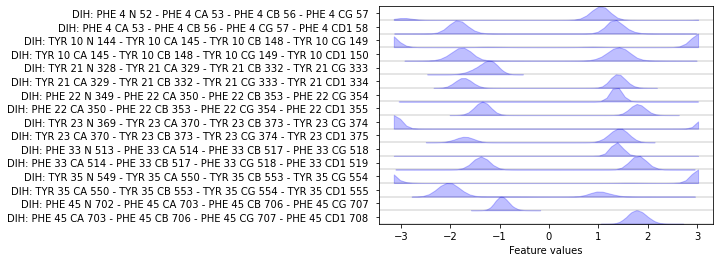

In [5]:
pyemma.plots.plot_feature_histograms(data, feature_labels=feat)

In [6]:
# Perform TICA
lag=100
n_feat = 16

inp = coor.source(traj_file, feat)
print('number of dimension = ', inp.dimension())
tica_obj = coor.tica(inp, lag=lag, dim=n_feat, kinetic_map=False) # kinetic_map=False, eigenvectors are not scaled by eigenvalues
Y= tica_obj.get_output()[0]
print('TICA components shape = ', Y.shape)

# Standardize output to be between -1 and 1

#Y = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)
Mean = np.mean(Y,axis=0)
Range = np.abs((np.max(Y, axis=0)-np.min(Y, axis=0))/2)
Y = (Y - Mean) / Range


number of dimension =  16
TICA components shape =  (103125, 16)


<ipython-input-7-ad0eb3e4c218>:11: RuntimeWarning: invalid value encountered in log
  implied_time = -lag/np.log(tica_obj.eigenvalues) * 10 # time units is 10 ns


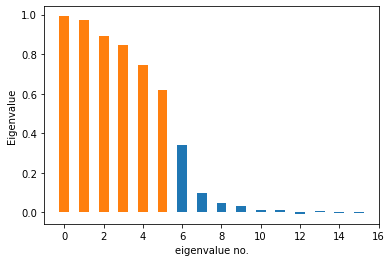

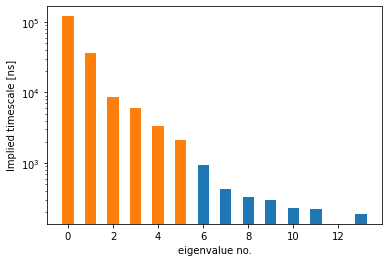

In [7]:
# Plot eigenvalues and implied timescales
no_tica = 6 #number of tica components to retain

plt.figure()
plt.bar(np.arange(len(tica_obj.eigenvalues)),tica_obj.eigenvalues,width=0.5)
plt.bar(np.arange(no_tica),tica_obj.eigenvalues[:no_tica],width=0.5)
plt.xlabel('eigenvalue no.')
plt.ylabel('Eigenvalue')

plt.figure()
implied_time = -lag/np.log(tica_obj.eigenvalues) * 10 # time units is 10 ns 
plt.bar(np.arange(len(tica_obj.eigenvalues)),implied_time,width=0.5)
plt.bar(np.arange(no_tica),implied_time[:no_tica],width=0.5)
plt.xlabel('eigenvalue no.')
plt.ylabel('Implied timescale [ns]')
plt.yscale('log')


In [8]:
res_list = "PHE4 TYR10 TYR21 PHE22 TYR23 PHE33 TYR35 PHE45".split(' ')
feat_list = []
for res in res_list:
    for id in [1,2]:
        for s in ['']:
            feat_list.append(f'{s}chi{id} {res}')

print(feat_list)

['chi1 PHE4', 'chi2 PHE4', 'chi1 TYR10', 'chi2 TYR10', 'chi1 TYR21', 'chi2 TYR21', 'chi1 PHE22', 'chi2 PHE22', 'chi1 TYR23', 'chi2 TYR23', 'chi1 PHE33', 'chi2 PHE33', 'chi1 TYR35', 'chi2 TYR35', 'chi1 PHE45', 'chi2 PHE45']


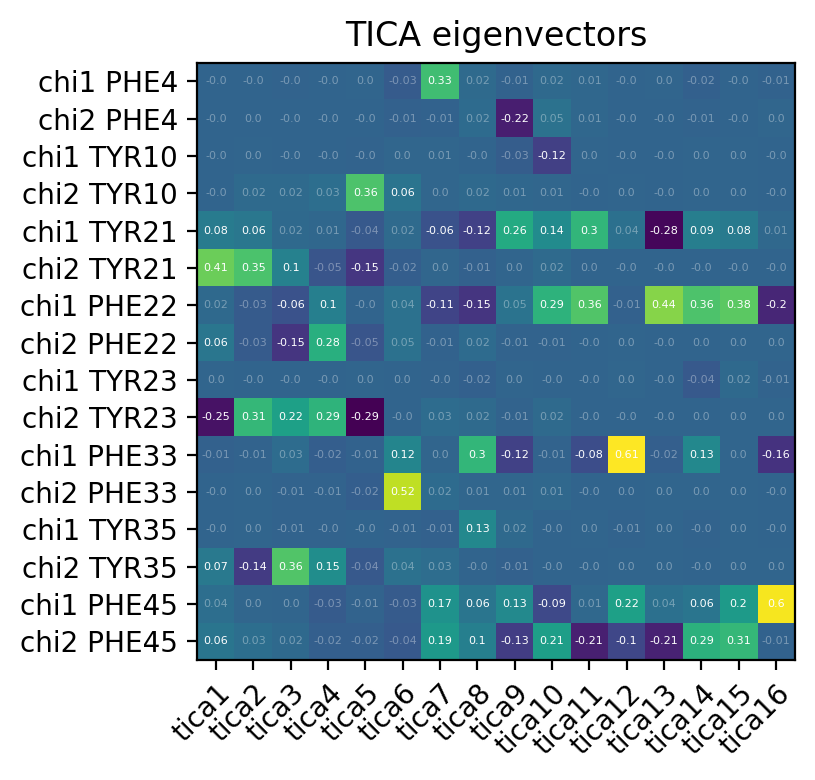

In [9]:
# Eigenvectors
eigenvectors = tica_obj.eigenvectors
col_sum = np.abs(eigenvectors).sum(axis=0,keepdims=1)
eigenvectors = eigenvectors / col_sum

rows = feat_list
cols = ['tica'+str(i+1) for i in range(eigenvectors.shape[1])]

fig, ax = plt.subplots(dpi=200)
im = ax.imshow(eigenvectors)

# We want to show all ticks...
ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(rows)))
# ... and label them with the respective list entries
ax.set_xticklabels(cols)
ax.set_yticklabels(rows)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(rows)):
    for j in range(len(cols)):
        val = np.round(eigenvectors[i, j],2)
        thresold = 0.05
        text = ax.text(j, i, val, ha="center", va="center", 
                       color="w", 
                       alpha=1 if np.abs(val) > thresold else 0.35,
                       fontsize=4)

ax.set_title("TICA eigenvectors")
fig.tight_layout()
plt.show()

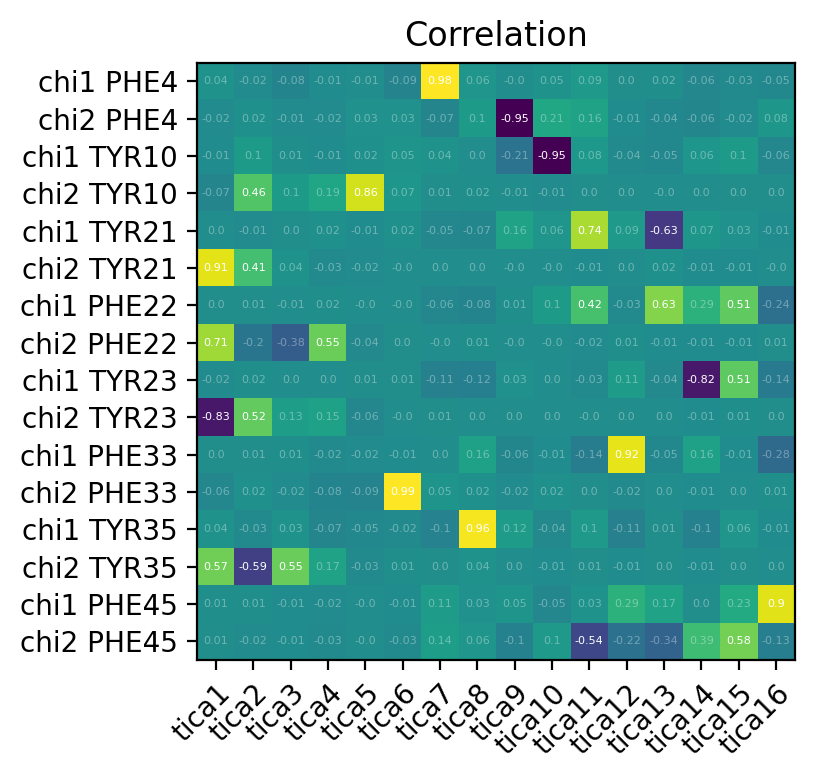

In [10]:
# Correlation between TICA components and input features
correlation = tica_obj.feature_TIC_correlation

rows = feat_list
cols = ['tica'+str(i+1) for i in range(correlation.shape[1])]

fig, ax = plt.subplots(dpi=200)
im = ax.imshow(correlation,)

# We want to show all ticks...
ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(rows)))
# ... and label them with the respective list entries
ax.set_xticklabels(cols)
ax.set_yticklabels(rows)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(rows)):
    for j in range(len(cols)):
        val = np.round(correlation[i, j],2)
        thresold = 0.4
        text = ax.text(j, i, val, ha="center", va="center", 
                       color="w", 
                       alpha=1 if np.abs(val) > thresold else 0.35,
                       fontsize=4)

ax.set_title("Correlation")
fig.tight_layout()
plt.show()

In [12]:
# Create COLVAR df

columns = ['tica'+str(i+1) for i in range(no_tica)]

colvar = pd.DataFrame(data=Y[:,:no_tica],columns=columns)

colvar.to_csv('COLVAR_tmp',sep=' ', header = False)

# Save to file
!echo -e "#! FIELDS tica1 tica2 tica3 tica4 tica5 tica6" > COLVAR
!cat COLVAR_tmp >> COLVAR
!head COLVAR
!mv COLVAR {folder}COLVAR
!rm COLVAR_tmp


#! FIELDS tica1 tica2 tica3 tica4 tica5 tica6
0 0.91468054 -0.48288155 0.17808062 0.08236374 0.49456695 0.5756004
1 0.94376886 -0.44390762 0.119904466 0.05598628 0.5699527 0.5809726
2 0.86591905 -0.37593216 0.115076184 0.14909317 0.57875854 0.59372985
3 0.9397081 -0.48339072 0.12801675 0.058558907 0.47921672 0.4863315
4 0.91578496 -0.5109055 0.06929187 0.035653867 0.56144667 0.57684684
5 0.95413387 -0.44996116 0.11820618 0.1086513 0.50680107 0.5061452
6 0.9507535 -0.3726983 0.10045743 0.0011872288 0.46675277 0.5171559
7 0.83961207 -0.5369361 0.060798433 -0.020673195 0.5385465 0.57913435
8 0.9583868 -0.44110113 0.19802226 0.12224286 0.41081324 0.4855411


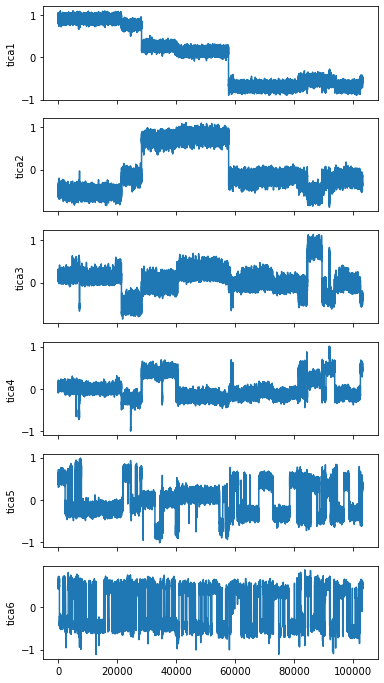

In [13]:
# plot time evolution of tica components
fig,axs=plt.subplots(no_tica,1,figsize=(6,12) ,sharex=True)
for i in range(no_tica):
    ax = axs[i]
    label = 'tica'+str(i+1)
    ax.plot(colvar[label])
    #ax.plot(Y[:,i])
    ax.set_ylabel(label)

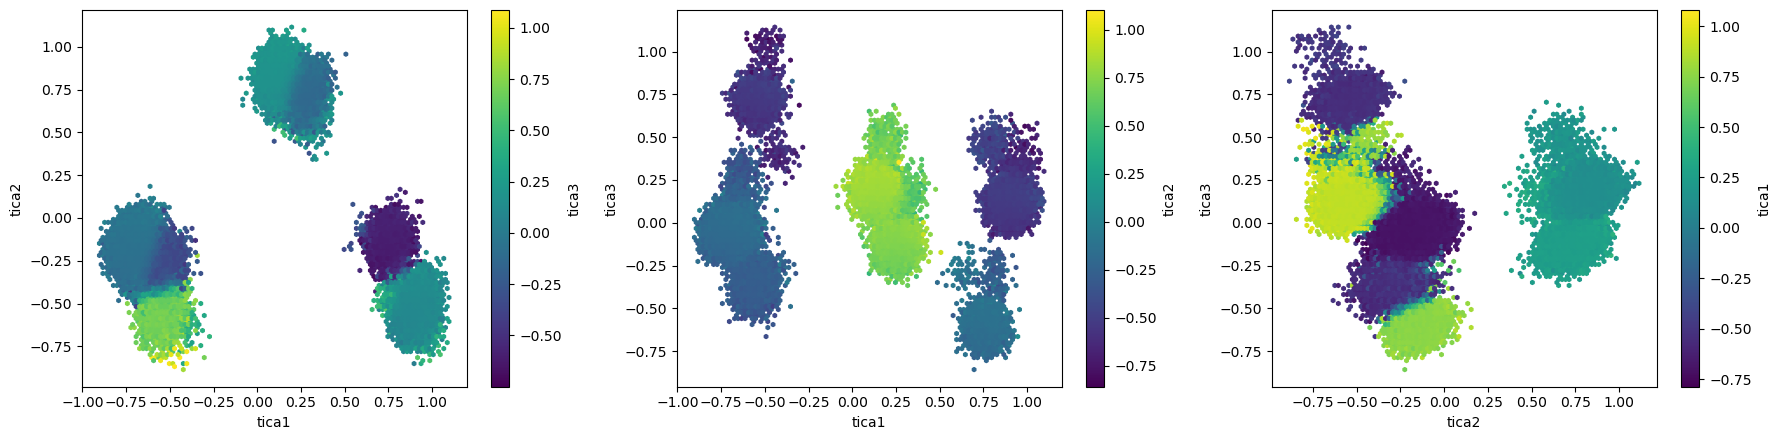

In [14]:
# scatter plot of tica components 
pairs = [['tica1','tica2'],['tica1','tica3'],['tica2','tica3']]
color = ['tica3','tica2','tica1']

fig, axs = plt.subplots(1,3,figsize=(18,4.5),dpi=100)
for k,(label_x,label_y) in enumerate(pairs):
    ax = axs[k]
    label_z = color[k]
    pp = ax.hexbin(colvar[label_x],colvar[label_y],C=colvar[label_z])#,bins=50)
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)
    cbar = plt.colorbar(pp,ax=ax)
    cbar.set_label(label_z)

plt.tight_layout()

## Load trajectory

In [15]:
# google drive folder
stride = 1

# load trajectory
traj_file = folder + "all_trj_10ns.trr"
topo_file = folder + "bpti-protein.pdb"

traj = md.load(traj_file, top=topo_file,stride=stride)

# load reference structure (used for Root-mean-square deviation [RMSD] analysis)
##ref_file = folder + "chignolin-ref-ca-DES.pdb"
##ref = md.load(ref_file)

# general setup 
kb = 0.00831441 #boltzmann constant in [kJ/mol]
temp = 300
kbt = kb * temp


In [20]:
# PRINT TOPOLOGY with atom properties (serial, name, element,residue_id,residue_name etc)
table, bonds = traj.top.to_dataframe()
table

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,N,N,1,ARG,0,C1
1,2,CA,C,1,ARG,0,C1
2,3,C,C,1,ARG,0,C1
3,4,O,O,1,ARG,0,C1
4,5,CB,C,1,ARG,0,C1
...,...,...,...,...,...,...,...
887,888,H,H,58,ALA,0,C1
888,889,HA,H,58,ALA,0,C1
889,890,HB1,H,58,ALA,0,C1
890,891,HB2,H,58,ALA,0,C1


## Compute descriptors and basins

In [17]:
from stateinterpreter.MD import Loader

In [24]:
file_dict = {
    'trajectory': 'all_trj_10ns.trr',
    'topology' : 'bpti-protein.pdb',
    'collective_vars': 'COLVAR'
}
stride = 10
#data = Loader(folder, file_dict, stride=stride,_DEV=True)

In [23]:
collective_vars = ['tica1', 'tica2', 'tica3']
bounds = [(-1,1)]*len(collective_vars)

In [25]:
#dataframe = data.load(collective_vars, bounds, num=20, memory_saver=False, )

data.approximate_FES(collective_vars, bounds, num=70)
CVs = data.colvar[collective_vars]
basins = data._basin_selection(fes_cutoff=5, memory_saver=True, splits=20)
#CA_DIST = data._CA_DISTANCES()
#HB = data._HYDROGEN_BONDS()
ANGLES = data._ANGLES()
#pd.concat([CVs, basins, CA_DIST,HB,ANGLES], axis=1)
colvar = pd.concat([CVs, basins, ANGLES], axis=1)

colvar.to_csv(folder+'dataframe',sep=' ')

  0%|          | 0/20 [00:00<?, ?it/s]

Detected 7 minima
True	 Approx	 Delta
[-0.55 -0.54  0.71]	 [-0.54 -0.54  0.71]	 [0.01 0.   0.  ]	
[ 0.9  -0.52  0.11]	 [ 0.91 -0.54  0.1 ]	 [0.01 0.01 0.01]	
[-0.57 -0.28 -0.33]	 [-0.57 -0.28 -0.33]	 [0. 0. 0.]	
[-0.7  -0.18 -0.06]	 [-0.71 -0.19 -0.07]	 [0.01 0.01 0.01]	
[ 0.76 -0.14 -0.6 ]	 [ 0.77 -0.13 -0.59]	 [0.01 0.01 0.01]	
[ 0.25  0.73 -0.13]	 [ 0.25  0.74 -0.13]	 [0.01 0.01 0.  ]	
[0.13 0.82 0.19]	 [0.13 0.83 0.19]	 [0.   0.01 0.  ]	


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


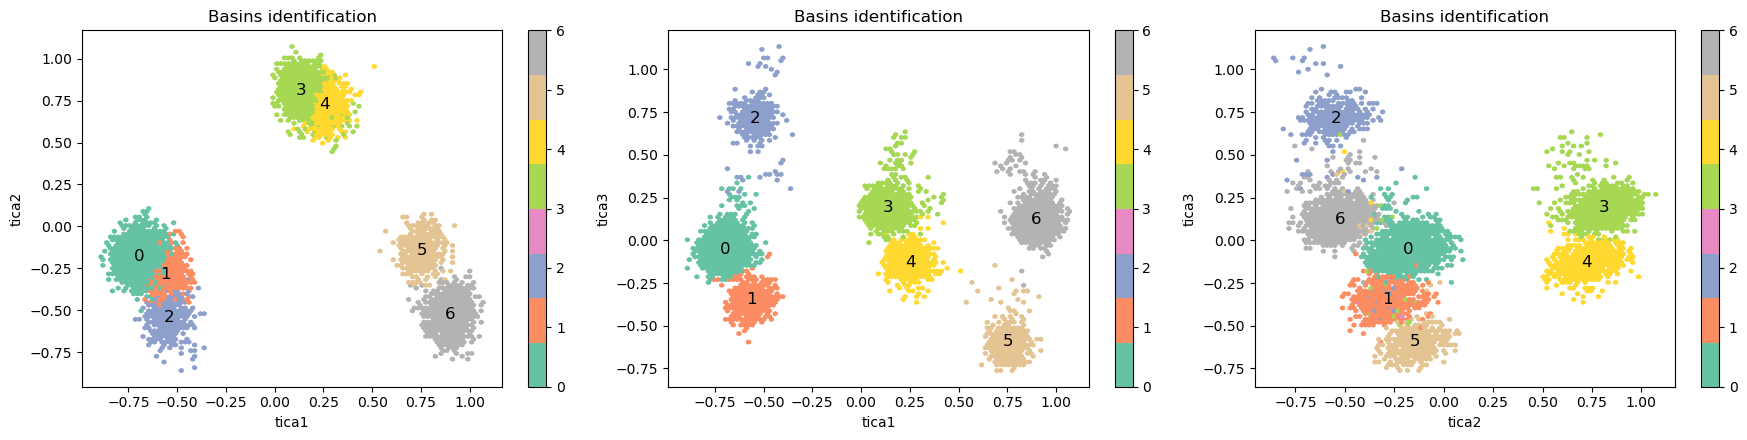

In [27]:
basins = colvar['basin'].unique()

def compute_basin_mean(df, basin, label_x, label_y):
    mx = df[df['basin'] == basin][label_x].mean()
    my = df[df['basin'] == basin][label_y].mean()
    return mx,my

# scatter plot of tica components 
pairs = [['tica1','tica2'],['tica1','tica3'],['tica2','tica3']]

fig, axs = plt.subplots(1,3,figsize=(18,4.5),dpi=100)
for k,(label_x,label_y) in enumerate(pairs):
    ax = axs[k]
    pp = colvar.plot.hexbin(label_x,label_y,C='basin',cmap='Set2',ax=ax)
    ax.set_title('Basins identification')
    #add basins labels
    for b in basins:
        mx,my = compute_basin_mean(colvar,b,label_x,label_y)
        text = ax.text(mx, my, b, ha="center", va="center", 
                       color="k", fontsize='large')

plt.tight_layout()

In [28]:
res_list = "PHE4 TYR10 TYR21 PHE22 TYR23 PHE33 TYR35 PHE45".split(' ')
feat_list = []
for res in res_list:
    for id in [1,2]:
        for s in ['sin_','cos_']:
            feat_list.append(f'SIDECHAIN {s}chi{id} {res}')

#print(feat_list)
#colvar[feat_list]

## Classification

In [29]:
from stateinterpreter.classifier import MD_Data, CV_path

In [43]:
colvar2 = colvar[(colvar['basin']==0 ) | (colvar['basin']==5 )]
colvar2[(colvar2['basin']==0) & (colvar2['selection']) ]

,Unnamed: 0,tica1,tica2,tica3,basin,selection,BACKBONE phi ARG1,BACKBONE cos_phi ARG1,BACKBONE sin_phi ARG1,BACKBONE phi PRO2,BACKBONE cos_phi PRO2,BACKBONE sin_phi PRO2,BACKBONE phi ASP3,BACKBONE cos_phi ASP3,BACKBONE sin_phi ASP3,BACKBONE phi PHE4,BACKBONE cos_phi PHE4,BACKBONE sin_phi PHE4,BACKBONE phi CYS5,BACKBONE cos_phi CYS5,BACKBONE sin_phi CYS5,BACKBONE phi LEU6,BACKBONE cos_phi LEU6,BACKBONE sin_phi LEU6,BACKBONE phi GLU7,BACKBONE cos_phi GLU7,BACKBONE sin_phi GLU7,BACKBONE phi PRO8,BACKBONE cos_phi PRO8,BACKBONE sin_phi PRO8,BACKBONE phi PRO9,BACKBONE cos_phi PRO9,BACKBONE sin_phi PRO9,BACKBONE phi TYR10,BACKBONE cos_phi TYR10,BACKBONE sin_phi TYR10,BACKBONE phi THR11,BACKBONE cos_phi THR11,BACKBONE sin_phi THR11,BACKBONE phi GLY12,...,SIDECHAIN sin_chi2 GLN31,SIDECHAIN chi2 PHE33,SIDECHAIN cos_chi2 PHE33,SIDECHAIN sin_chi2 PHE33,SIDECHAIN chi2 TYR35,SIDECHAIN cos_chi2 TYR35,SIDECHAIN sin_chi2 TYR35,SIDECHAIN chi2 ARG39,SIDECHAIN cos_chi2 ARG39,SIDECHAIN sin_chi2 ARG39,SIDECHAIN chi2 LYS41,SIDECHAIN cos_chi2 LYS41,SIDECHAIN sin_chi2 LYS41,SIDECHAIN chi2 ARG42,SIDECHAIN cos_chi2 ARG42,SIDECHAIN sin_chi2 ARG42,SIDECHAIN chi2 ASN43,SIDECHAIN cos_chi2 ASN43,SIDECHAIN sin_chi2 ASN43,SIDECHAIN chi2 ASN44,SIDECHAIN cos_chi2 ASN44,SIDECHAIN sin_chi2 ASN44,SIDECHAIN chi2 PHE45,SIDECHAIN cos_chi2 PHE45,SIDECHAIN sin_chi2 PHE45,SIDECHAIN chi2 LYS46,SIDECHAIN cos_chi2 LYS46,SIDECHAIN sin_chi2 LYS46,SIDECHAIN chi2 GLU49,SIDECHAIN cos_chi2 GLU49,SIDECHAIN sin_chi2 GLU49,SIDECHAIN chi2 ASP50,SIDECHAIN cos_chi2 ASP50,SIDECHAIN sin_chi2 ASP50,SIDECHAIN chi2 MET52,SIDECHAIN cos_chi2 MET52,SIDECHAIN sin_chi2 MET52,SIDECHAIN chi2 ARG53,SIDECHAIN cos_chi2 ARG53,SIDECHAIN sin_chi2 ARG53
5775,5775,-0.687054,-0.227630,-0.045272,0,True,-1.032704,0.512499,-0.858688,-0.908383,0.615021,-0.788510,-1.152577,0.406134,-0.913814,-1.449636,0.120864,-0.992669,-1.457177,0.113375,-0.993552,-1.326937,0.241450,-0.970413,-0.913878,0.610680,-0.791878,-1.305682,0.262020,-0.965063,-2.727752,-0.915583,-0.402129,-2.154273,-0.550928,-0.834552,1.356632,0.212531,0.977154,-1.097771,...,-0.280637,2.034565,-0.447322,0.894373,-1.949106,-0.369351,-0.929290,-2.845985,-0.956625,-0.291321,-2.997771,-0.989675,-0.143326,3.006244,-0.990854,0.134936,0.212777,0.977448,0.211175,-0.482699,0.885745,-0.464172,1.911293,-0.333955,0.942589,3.095987,-0.998960,0.045590,2.668046,-0.889957,0.456045,0.681780,0.776452,0.630176,-1.346816,0.222113,-0.975021,-3.009082,-0.991233,-0.132123
5776,5776,-0.699529,-0.204066,-0.020054,0,True,-1.174584,0.385926,-0.922530,-1.170150,0.390013,-0.920809,-1.184780,0.376501,-0.926416,-1.409679,0.160421,-0.987049,-1.654331,-0.083438,-0.996513,-1.717574,-0.146251,-0.989248,-1.162675,0.396885,-0.917868,-1.123250,0.432755,-0.901512,-2.363321,-0.712128,-0.702050,-2.335181,-0.692093,-0.721808,1.221471,0.342264,0.939604,-1.504094,...,-0.389189,2.050676,-0.461672,0.887051,-1.790473,-0.217914,-0.975968,-2.952100,-0.982100,-0.188360,-3.131410,-0.999948,-0.010183,2.779569,-0.935182,0.354168,0.277470,0.961751,0.273923,-0.003928,0.999992,-0.003928,1.891296,-0.315041,0.949078,3.046825,-0.995513,0.094626,-0.799288,0.697217,-0.716860,0.582951,0.834842,0.550490,-1.119374,0.436246,-0.899827,-3.067461,-0.997254,-0.074064
5777,5777,-0.732013,-0.190003,-0.069319,0,True,-1.035027,0.510503,-0.859876,-0.682154,0.776216,-0.630467,-1.288593,0.278472,-0.960444,-1.422656,0.147599,-0.989047,-1.301413,0.266137,-0.963935,-1.798851,-0.226083,-0.974108,-1.362212,0.207076,-0.978325,-1.192153,0.369660,-0.929167,-2.425420,-0.754324,-0.656502,-1.450815,0.119694,-0.992811,1.662913,-0.091986,0.995760,-1.468697,...,-0.302544,1.909654,-0.332410,0.943135,-2.057747,-0.467934,-0.883764,-3.038161,-0.994656,-0.103247,3.089574,-0.998647,0.051996,1.224159,0.339737,0.940521,0.085756,0.996325,0.085651,-0.483087,0.885565,-0.464515,1.843845,-0.269669,0.962953,2.900201,-0.971006,0.239054,3.002869,-0.990393,0.138279,-2.341923,-0.696944,-0.717126,0.694276,0.768517,0.639829,2.778837,-0.934922,0.354852
5778,5778

In [31]:
colvar = pd.read_csv(folder+'dataframe', sep=' ')
model = MD_Data(colvar)
select_feat = "|".join(feat_list)
#print(select_feat)
#select_feat = 'sin_|cos_'
sample = model.sample(250, regex_filter = select_feat)

In [32]:
C_range = np.geomspace(2, 100, 25)
kwargs = {'LASSO':True, 'max_iter':1000}
dset = sample.train_test_dataset()
n_examples = dset[0].shape[0]
C_range_in = C_range/n_examples
cvpath = CV_path(dset, sample.features, quadratic_kernel=False)

In [33]:
cvpath.compute(C_range_in,multi_class='ovr', **kwargs);

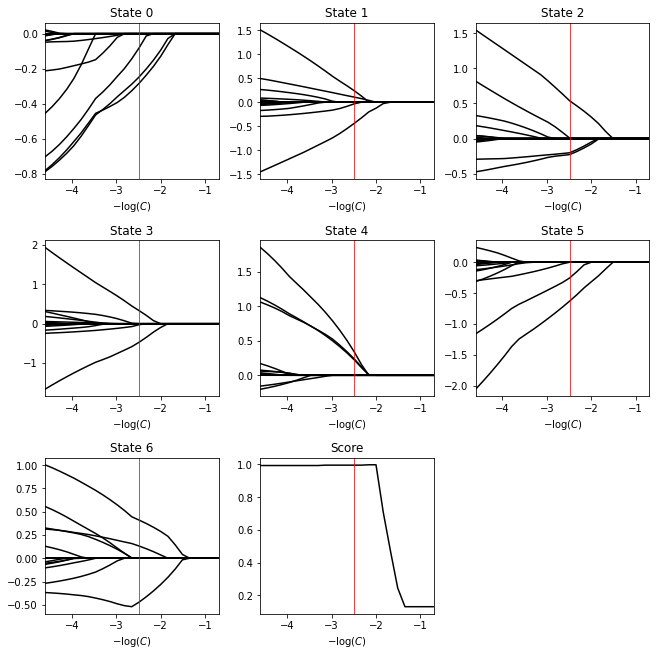

In [35]:
C = np.exp(2.5)
cvpath.plot(C);

## **Relevant features analysis**

In [36]:
cvpath.print_relevant_features(C)

State 0:
	 54.2% | SIDECHAIN sin_chi2 TYR21
	 41.2% | SIDECHAIN sin_chi2 PHE22
	 4.5%  | SIDECHAIN sin_chi2 TYR35
State 1:
	 73.9% | SIDECHAIN sin_chi2 TYR21
	 21.4% | SIDECHAIN sin_chi2 PHE22
	 4.2%  | SIDECHAIN cos_chi1 TYR10
	 0.4%  | SIDECHAIN sin_chi2 TYR35
State 2:
	 75.6% | SIDECHAIN sin_chi2 TYR35
	 13.6% | SIDECHAIN sin_chi2 TYR21
	 10.7% | SIDECHAIN sin_chi2 PHE22
	 0.0%  | SIDECHAIN sin_chi2 TYR23
State 3:
	 66.4% | SIDECHAIN sin_chi2 PHE22
	 33.4% | SIDECHAIN sin_chi2 TYR21
	 0.2%  | SIDECHAIN sin_chi2 TYR35
State 4:
	 52.0% | SIDECHAIN sin_chi2 TYR23
	 25.4% | SIDECHAIN sin_chi2 PHE22
	 22.6% | SIDECHAIN sin_chi2 TYR21
State 5:
	 85.9% | SIDECHAIN sin_chi2 TYR23
	 14.1% | SIDECHAIN sin_chi2 TYR35
State 6:
	 54.6% | SIDECHAIN sin_chi2 TYR23
	 41.2% | SIDECHAIN sin_chi2 TYR35
	 4.2%  | SIDECHAIN cos_chi2 TYR35


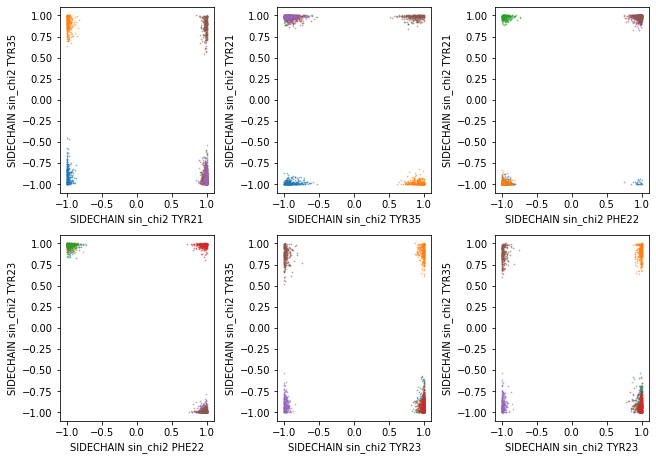

In [ ]:
cvpath.plot_relevant_features(C, model, n_configs=250)
plt.show()

In [37]:
relevant_feat = cvpath.relevant_features(C)

unique_features = set()
for state in relevant_feat.values():
    for feat in state:
        unique_features.add(feat[1])

unique_features

{'SIDECHAIN cos_chi1 TYR10',
 'SIDECHAIN cos_chi2 TYR35',
 'SIDECHAIN sin_chi2 PHE22',
 'SIDECHAIN sin_chi2 TYR21',
 'SIDECHAIN sin_chi2 TYR23',
 'SIDECHAIN sin_chi2 TYR35'}

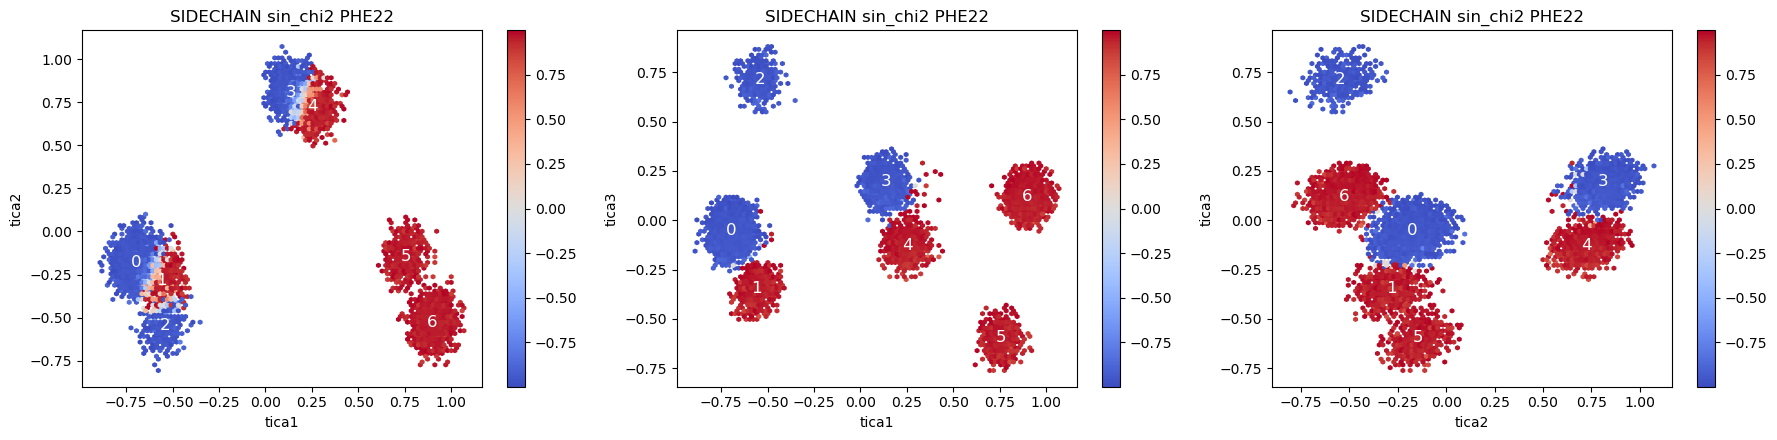

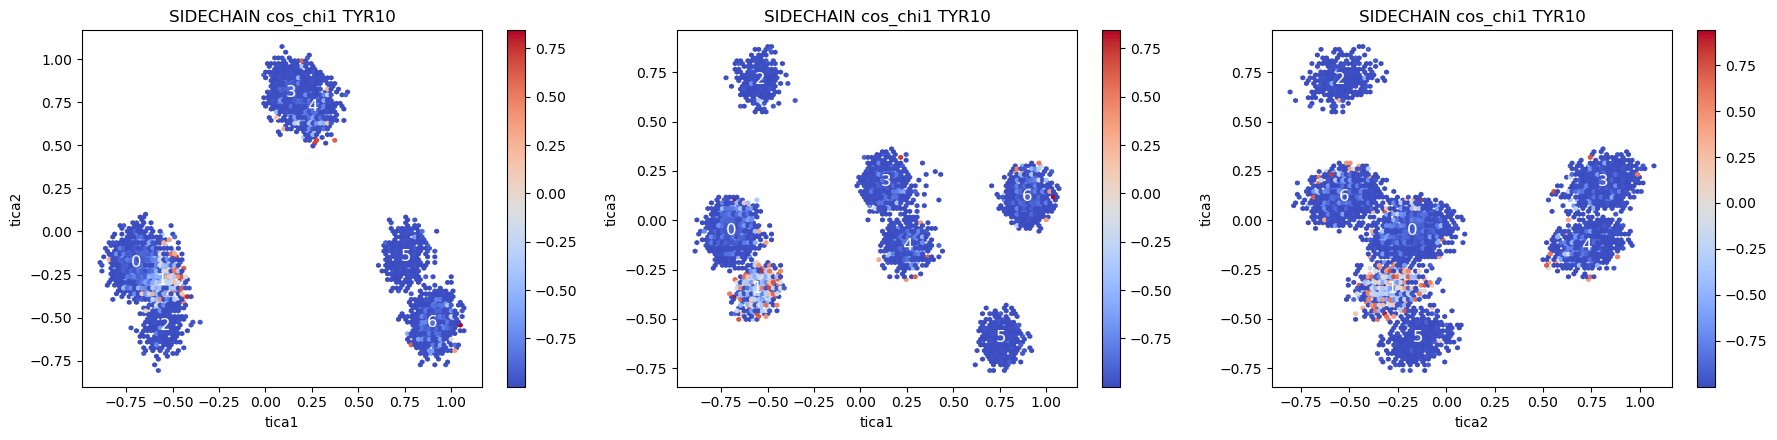

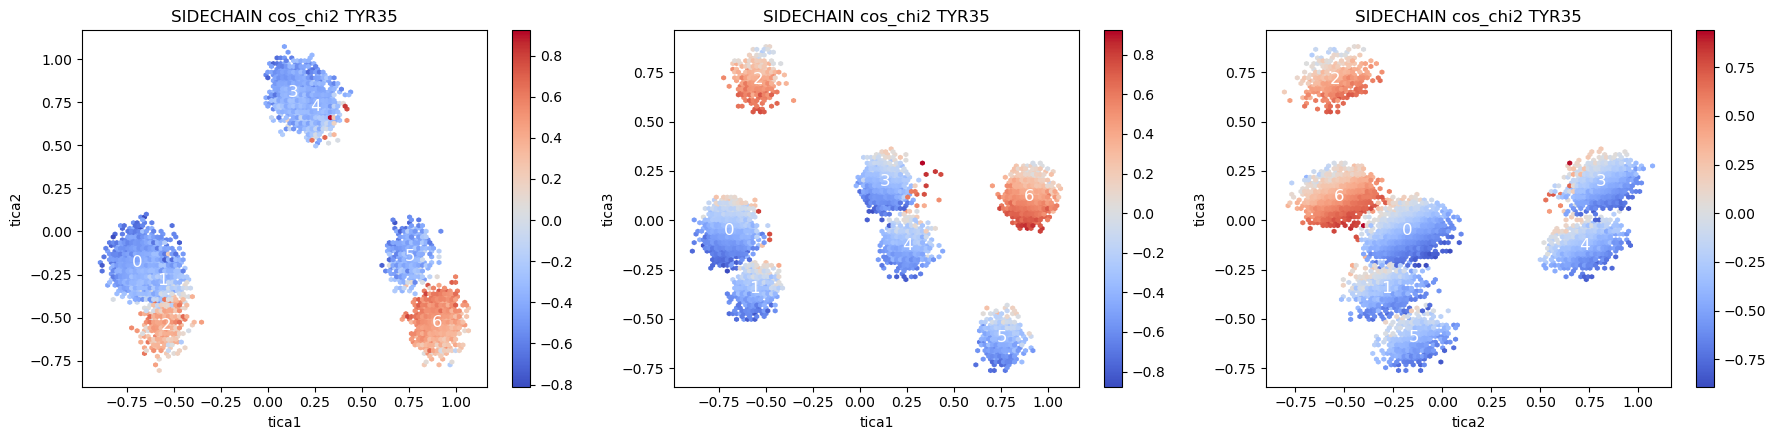

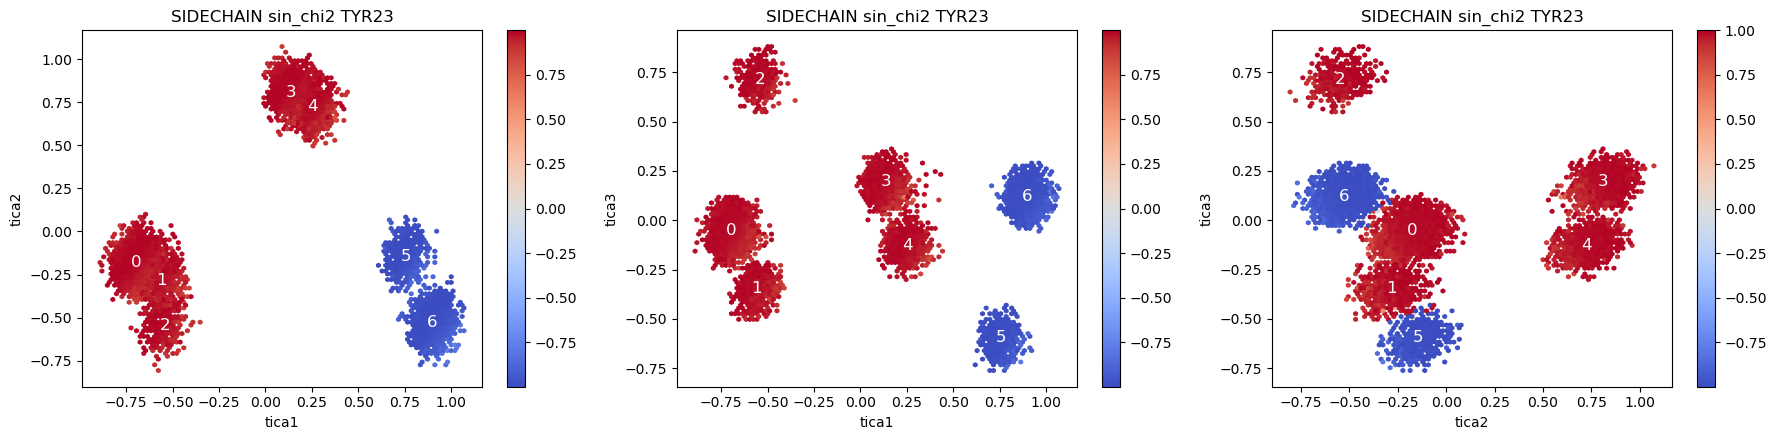

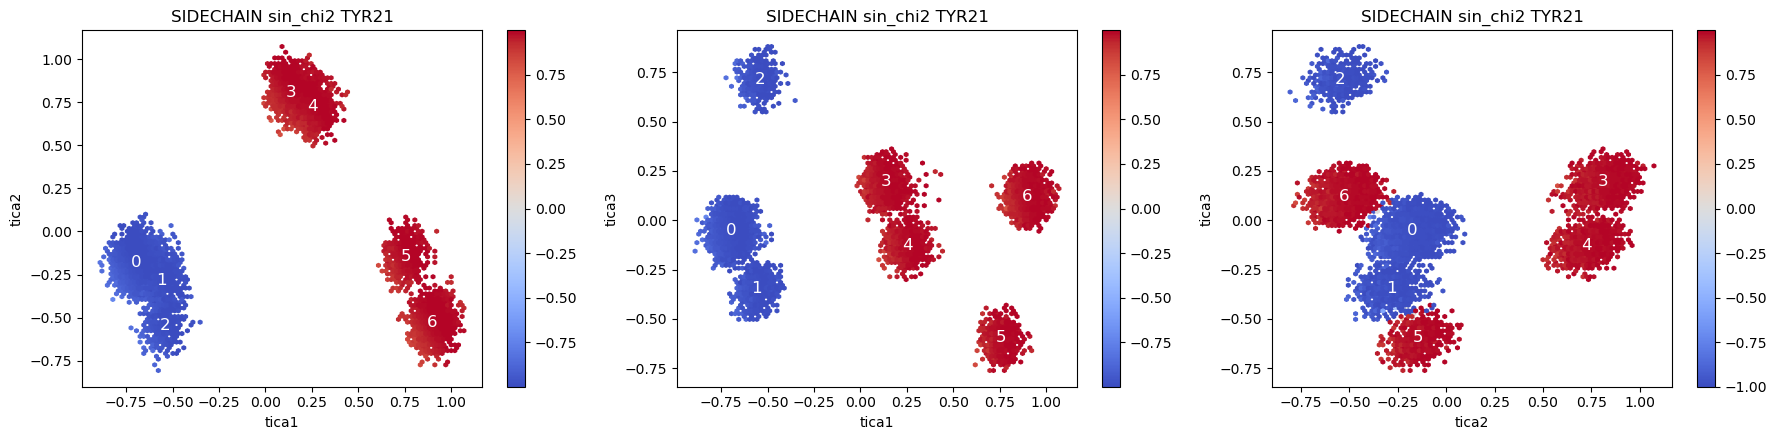

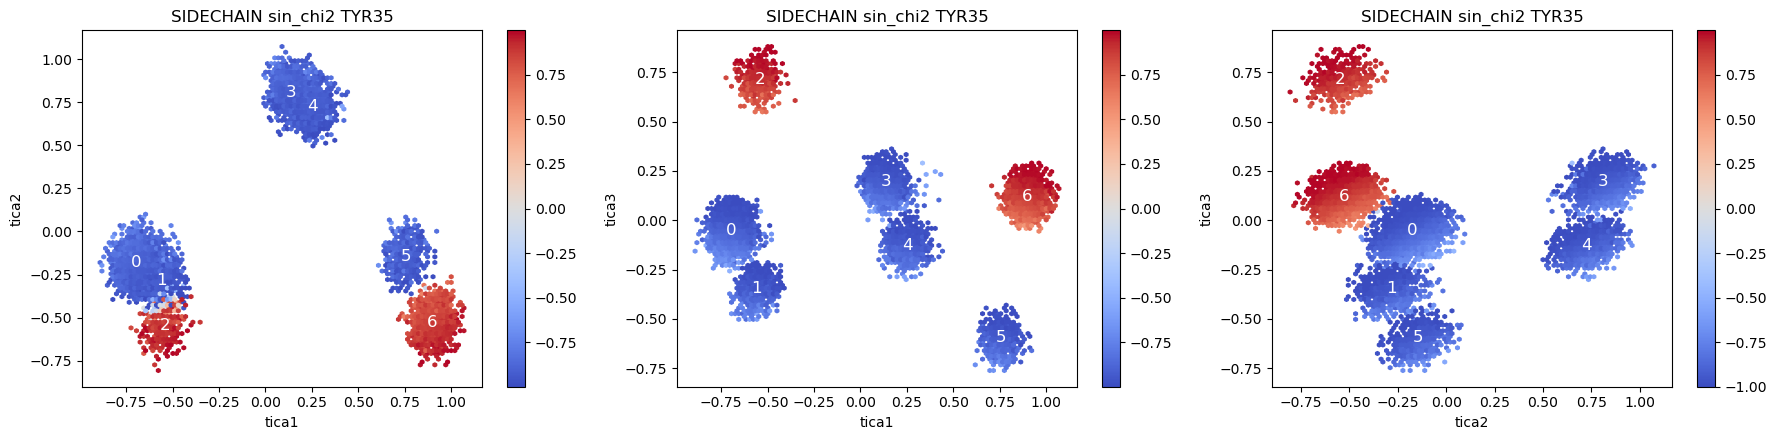

In [38]:
# scatter plot of tica components 
pairs = [['tica1','tica2'],['tica1','tica3'],['tica2','tica3']]

for feat in unique_features:
    fig, axs = plt.subplots(1,3,figsize=(18,4.5),dpi=100)
    for k,(label_x,label_y) in enumerate(pairs):
        ax = axs[k]
        pp = colvar[colvar['selection']==1].plot.hexbin(label_x,label_y,C=feat,cmap='coolwarm',ax=ax)
        ax.set_title(feat)
        #add basins labels
        for b in basins:
            mx,my = compute_basin_mean(colvar,b,label_x,label_y)
            text = ax.text(mx, my, b, ha="center", va="center", 
                        color="w", fontsize='large')
    plt.tight_layout()

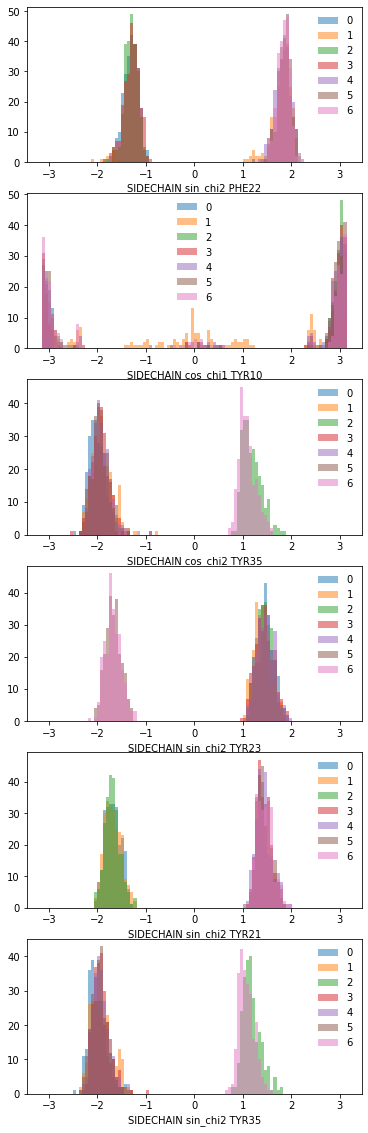

In [39]:
fig, axs = plt.subplots(len(unique_features),1,figsize=(6,20))

for j,feat in enumerate(list(unique_features)):
    sample_feat = model.sample_feature(feat, get_angle=True, n_configs=250)
    ax = axs[j]
    ax.set_xlabel(feat) 

    for i in range(model.n_clusters):
        ax.hist(sample_feat[i],bins=100,range=(-np.pi, np.pi), alpha=0.5,label=i)
        ax.set_xlabel(feat)
    
    ax.legend(frameon=False)



## Quadratic kernel

In [40]:
prunedcv = cvpath.get_pruned_CVpath(C)

In [41]:
prunedcv.compute(C_range_in, **kwargs);

/home/novelli/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/novelli/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/novelli/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


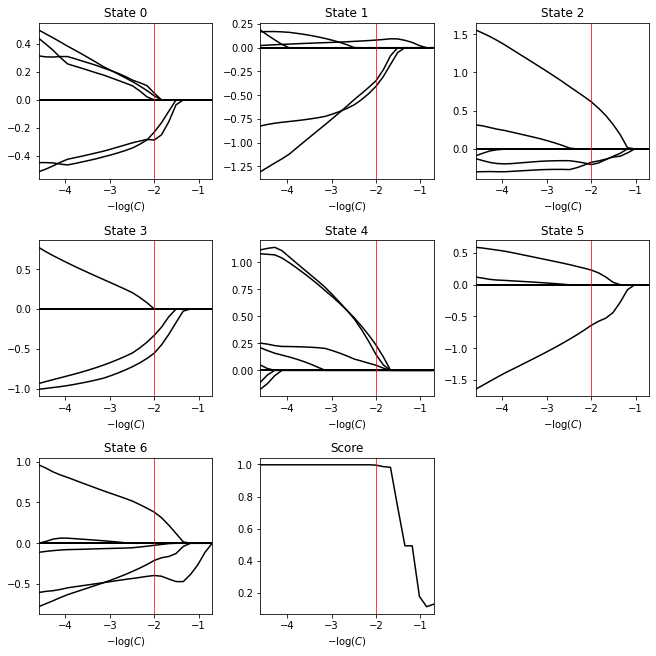

In [42]:
C = np.exp(2)
prunedcv.plot(C);

In [43]:
prunedcv.print_relevant_features(C)

State 0:
	 59.5% | SIDECHAIN sin_chi2 TYR21
	 38.2% | SIDECHAIN sin_chi2 PHE22
	 1.7%  | SIDECHAIN sin_chi2 TYR21 || SIDECHAIN sin_chi2 TYR35
	 0.6%  | SIDECHAIN sin_chi2 TYR21 || SIDECHAIN sin_chi2 PHE22
State 1:
	 56.4% | SIDECHAIN sin_chi2 TYR21 || SIDECHAIN sin_chi2 PHE22
	 41.3% | SIDECHAIN sin_chi2 TYR21
	 2.2%  | SIDECHAIN cos_chi1 TYR10 || SIDECHAIN cos_chi1 TYR10
State 2:
	 83.9% | SIDECHAIN sin_chi2 TYR35
	 9.4%  | SIDECHAIN sin_chi2 PHE22 || SIDECHAIN sin_chi2 TYR35
	 6.7%  | SIDECHAIN sin_chi2 TYR21 || SIDECHAIN sin_chi2 TYR35
State 3:
	 73.9% | SIDECHAIN sin_chi2 TYR21 || SIDECHAIN sin_chi2 PHE22
	 26.1% | SIDECHAIN sin_chi2 PHE22
	 0.0%  | SIDECHAIN sin_chi2 TYR21
State 4:
	 69.9% | SIDECHAIN sin_chi2 PHE22 || SIDECHAIN sin_chi2 TYR23
	 27.3% | SIDECHAIN sin_chi2 TYR21
	 2.8%  | SIDECHAIN sin_chi2 PHE22
State 5:
	 88.4% | SIDECHAIN sin_chi2 TYR23
	 11.6% | SIDECHAIN sin_chi2 TYR23 || SIDECHAIN sin_chi2 TYR35
State 6:
	 45.1% | SIDECHAIN sin_chi2 TYR23 || SIDECHAIN sin_chi